# Normalizing HTML Data
## By Ivy Nangalia and Evan Flynn

### Importing

In [463]:
# importing libraries
import numpy as np
import pandas as pd

In [464]:
# initializing column names
colnames = ['User', 'church_avg', 'resort_avg', 'beach_avg', 'park_avg', 'theater_avg',
       'museum_avg', 'mall_avg', 'zoo_avg', 'restaurants_avg', 'bars_avg',
       'local_services_avg', 'burger_pizza_avg', 'hotel_avg', 'juice_avg',
       'art_avg', 'dance_avg', 'pool_avg', 'gym_avg', 'bakery_avg',
       'beauty_avg', 'spa_avg', 'cafe_avg', 'viewpoint_avg', 'monument_avg',
       'garden_avg']

In [465]:
#used copilot for pandas read_csv function
data = pd.read_csv('google_review_ratings.csv')
data.columns = colnames
# used copilot to drop user column
data = data.drop("User", axis=1) 
data = data.fillna(0.0)

We ran into an issue where `data["local_services_avg"]` was imported as an array of strings instead of floats. We had a hard time changing the datatype of the entire column because at `data["local_services_avg"][2712]` the value was `"2\t2"`. We ended up removing this anomaly and typecasting the rest of the data using a for loop.

In [466]:
x = pd.array(np.zeros(len(data["local_services_avg"])))

for i in range(0, len(data["local_services_avg"])-1):
    try:
        x[i] = float(data["local_services_avg"][i])
    except:
        print(i)
        x[i] = float(0.0)

data["local_services_avg"] = x

2712


### Initial Data Exploration

Our focus was to explore voluntary response bias in reviews. Statistically, we'd expect to see a mean rating of 2.5 stars per user (assuming a 1-5 scale). However, it appears that the mean rating was closer to 2, which indicates a right skew. 

Note: When testing out giving low ratings, we noted that Google Maps does not allow users to give reviews below 1 star. We still chose to use a 2.5 value since there were some average values below 1, indicating that this dataset perhaps accounts for that, or users were able to give zero stars.

In [504]:
x = data["bars_avg"].to_list()
print(sorted(x)[0:10]) # there are values lower than 1

[0.81, 0.81, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.82, 0.83]


In [502]:
data["user_average"] = data.apply(
    lambda row: row[row.apply(
        lambda x: isinstance(x, (int, float))) # ensures average only counts floats
        & (row != 0)].mean(), #ensures average does not count zeros
        axis=1)
# copilot was used for lambda aggfunc
print(data["user_average"].mean())

2.015920422439587


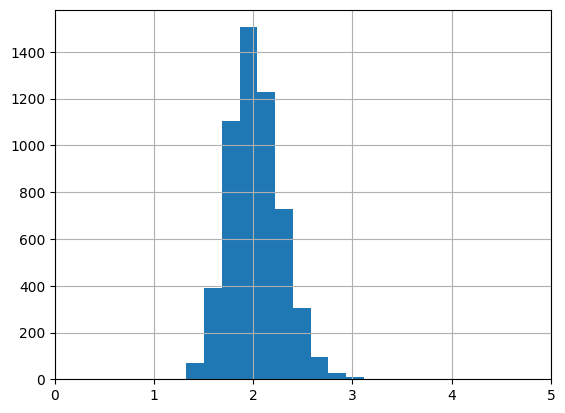

In [482]:
import matplotlib.pyplot as plt
data["user_average"].hist()
plt.xlim(0, 5) # used copilot for matplotlib help
plt.show()


We aimed to correct for this by getting the difference between the sample mean (of the user) and the expected mean (2.5 stars).

In [468]:
data["skew"] = data["user_average"] - 2.5

In [469]:
unskew = data
x = unskew["skew"]
unskew = unskew.drop("skew", axis=1)
unskew["skew"] = x # get rid of initial mean function


In [470]:
unskew = unskew.apply(lambda row: row[row.apply # subtracts skew from non-zero values
                             (lambda y: isinstance(y, (int, float)))
                             & (row != 0)] # used AI to ignore zero-values
                             - x, 
                             axis=0)
unskew = unskew.fillna(0)

In [471]:
unskew = unskew.drop(labels=["user_average"], axis=1)
unskew["user_average"] = unskew.apply(lambda row: row[row.apply(
    lambda x: isinstance(x, (int, float))) 
    & (row != 0)].mean(), # creates new user average
    axis=1)

In [472]:
# copy and pasted existing copilot code, and used .to_dict() method
raw = data.apply(lambda col: col[col.apply(lambda x: isinstance(x, (int, float))) & (col != 0)].mean(), axis= 0).to_dict()
normalized = unskew.apply(lambda col: col[col.apply(lambda x: isinstance(x, (int, float))) & (col != 0)].mean(), axis= 0).to_dict()
# fix normalized skew
normalized["skew"] = 0.0

print(raw)
print(normalized)

{'church_avg': 1.5096768675156813, 'resort_avg': 2.358613492359299, 'beach_avg': 2.4911573734409393, 'park_avg': 2.7968859970674487, 'theater_avg': 2.958940615835777, 'museum_avg': 2.8934897360703813, 'mall_avg': 3.3513947947214073, 'zoo_avg': 2.5407954545454543, 'restaurants_avg': 3.1260190615835772, 'bars_avg': 2.8327291055718473, 'local_services_avg': 2.550364869820315, 'burger_pizza_avg': 2.078339138405133, 'hotel_avg': 2.1255113636363636, 'juice_avg': 2.1908614369501467, 'art_avg': 2.208191489361702, 'dance_avg': 1.2177994011976048, 'pool_avg': 1.0405565601768134, 'gym_avg': 1.0108335210633026, 'bakery_avg': 1.1998390022675738, 'beauty_avg': 1.196576754385965, 'spa_avg': 1.0860696619950536, 'cafe_avg': 1.8687008413226376, 'viewpoint_avg': 1.6211893674815678, 'monument_avg': 1.627900573613767, 'garden_avg': 1.81, 'user_average': 2.120645714017358, 'skew': -0.3793542859826422}
{'church_avg': 1.8980891714816805, 'resort_avg': 2.7436446901673333, 'beach_avg': 2.8707486592449833, 'park

In [473]:
means = pd.DataFrame([raw, normalized]).transpose()
means.columns = ["raw", "normalized"]
means = means.drop(["skew", "user_average"], axis=0)
means["difference"] = means["normalized"] - means["raw"]
#means[:"church_avg"]


In [474]:
for n in data["garden_avg"]:
    if n > 0.0:
        print(n)

# removing "garden_avg" because of low n count
        
means = means.drop("garden_avg", axis=0)

1.04
2.58


In [475]:
means["difference"].mean()

0.3873730897663091

<Axes: >

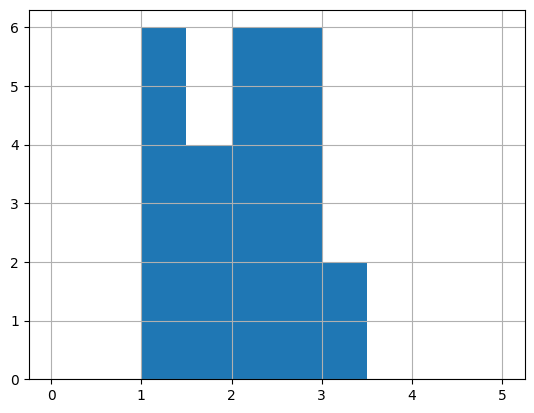

In [476]:
means["raw"].hist(range=(0,5))

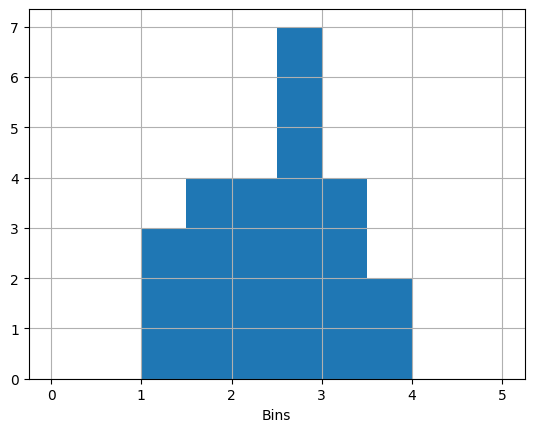

In [477]:
means["normalized"].hist(range=(0,5))
#plt.xlim(0, 5)
plt.xlabel('Bins')
plt.show()


$$k = $$

In [480]:
means["difference"].max() - means["difference"].min()

0.03270381610615902

In [479]:
def adjust(x: float) -> float:
    k = float(means["difference"].mean())
    adjusted = (-k/2.5)*(x-5)+x
    return adjusted

k = float(means["difference"].mean())

tests = []
for x in range(0, 5000):
    tests.append(adjust(x/1000))

#print(adjust(5))
print(np.mean(tests))
print(adjust(2.5))
print(adjust(1))


2.8869505643842626
2.8873730897663092
1.6197969436260946
